# EEG data processing

## Setup Environment

In [1]:
import os

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    IN_GOOGLE_DRIVE = True
except Exception:
    IN_GOOGLE_DRIVE = False

In [3]:
os.getcwd()

'/tf/codes/projects/eeg_tests2/src'

In [4]:
PROJECT_FOLDER = 'eeg_tests2/src'
if IN_GOOGLE_DRIVE:
    PATH_TO_PROJECT = '/content/gdrive/MyDrive/projects/'
    FOLDER_PATH = os.path.join(PATH_TO_PROJECT, PROJECT_FOLDER)
elif PROJECT_FOLDER not in os.getcwd():
    PATH_TO_PROJECT = '/tf/codes/projects/'
    FOLDER_PATH = os.path.join(PATH_TO_PROJECT, PROJECT_FOLDER)
else:
    FOLDER_PATH = os.getcwd()

In [5]:
FOLDER_PATH

'/tf/codes/projects/eeg_tests2/src'

In [6]:
%cd '{FOLDER_PATH}'

/tf/codes/projects/eeg_tests2/src


In [7]:
%pwd

'/tf/codes/projects/eeg_tests2/src'

## Getting The Data

In [ ]:
!pip install mat73

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import copy

In [ ]:
# data files
%ls 'data'

clean/  gvsparticipantinfo.mat  READY4DL_500.mat


### Inputs

The shape of the data is **20** (PD) or **22** (HC) cells and each cell which is for each subject is **27** channels x **2000** time points x **10** trials.  
For PD patients we have collected the data in 2 conditions: Off Medication which means they refused to take their medication (PD1) and On Medication is for the time they took their medication (PD2)

In [ ]:
READY4DL_500 = sio.loadmat('data/READY4DL_500.mat')
READY4DL_500.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ALL', 'ALL_HC_GVS_OFF', 'ALL_HC_GVS_ON', 'ALL_PD_GVSOFF_MEDOFF', 'ALL_PD_GVSOFF_MEDON', 'ALL_PD_GVSON_MEDOFF', 'ALL_PD_GVSON_MEDON', 'labels'])

In [ ]:
data_keys = ['ALL_HC_GVS_OFF', 'ALL_PD_GVSOFF_MEDOFF', 'ALL_PD_GVSOFF_MEDON']

In [ ]:
for key in data_keys:
    print(READY4DL_500[key].shape)

(22, 60)
(20, 60)
(20, 60)


In [ ]:
def get_data(items, keys):
    all_data = list()
    for key in keys:
        for item in items[key]:
            all_data.append({'data':item})
    return all_data

In [ ]:
# shamdata_tlgo proccess

all_data = get_data(READY4DL_500, data_keys)

In [ ]:
len(all_data)

62

### Outputs

In [ ]:
gvsparticipantinfo = sio.loadmat('data/gvsparticipantinfo.mat')
gvsparticipantinfo.keys()

dict_keys(['__header__', '__version__', '__globals__', 'hcinfo', 'hcinfonames', 'pdinfo', 'pdinfonames'])

In [ ]:
outputs_age = [
    *gvsparticipantinfo['hcinfo'][:, 0].tolist(),
    *gvsparticipantinfo['pdinfo'][:, 0].tolist(),
    *gvsparticipantinfo['pdinfo'][:, 0].tolist(),
]
len(outputs_age)

62

In [ ]:
outputs_gender = [
    *gvsparticipantinfo['hcinfo'][:, 1].tolist(),
    *gvsparticipantinfo['pdinfo'][:, 1].tolist(),
    *gvsparticipantinfo['pdinfo'][:, 1].tolist(),
]
len(outputs_gender)

62

In [ ]:
has_pd = [*[0] * 22, *[1]*40]
len(has_pd)

62

In [ ]:
taken_med = [*[0] * 22, *[0]*20, *[1]*20]
len(taken_med)

62

In [ ]:
UPDRS_string = '26 17 11 37 29 8 39 35 12 30 13 31 34 32 14 21 29 20 18 14'.split()
UPDRS = [int(x) for x in UPDRS_string]
all_UDPRS = [*[0]*22, *UPDRS, *UPDRS]
len(all_UDPRS)

62

### Creating a clean data dictionary

In [ ]:
for i in range(len(outputs_age)):
    all_data[i]['age'] = outputs_age[i]
    all_data[i]['gender'] = outputs_gender[i]
    all_data[i]['has_pd'] = has_pd[i]
    all_data[i]['taken_med'] = taken_med[i]
    all_data[i]['UPDRS'] = all_UDPRS[i]

### Check for nan

In [ ]:
for i in range(len(all_data)):
    for j in range(all_data[i]['data'].shape[0]):
        current_trial = all_data[i]['data'][j]
        if np.isnan(current_trial).any() != 0:
            print(i, j)

### Some Analysis

In [ ]:
df = pd.DataFrame(all_data)
df

,data,age,gender,has_pd,taken_med,UPDRS
0,"[[[0.4386822858566465, 0.4793236167114357, 0.4...",65,1,0,0,0
1,"[[[0.3634937413088139, 0.42090980923134125, 0....",78,1,0,0,0
2,"[[[0.43592762011065456, 0.4311134018811787, 0....",72,1,0,0,0
3,"[[[0.47486760758308577, 0.542854275784628, 0.5...",71,0,0,0,0
4,"[[[0.5361903678537211, 0.5343775091532127, 0.4...",67,0,0,0,0
...,...,...,...,...,...,...
57,"[[[0.5206956269354001, 0.5404680091802685, 0.5...",70,0,1,1,21
58,"[[[0.5573232158235693, 0.5636588162080876, 0.4...",60,0,1,1,29
59,"[[[0.44038808715609135, 0.46312595634449283, 0...",57,0,1,1,20
60,"[[[0.4996925908931075, 0.46702347101618, 0.444...",65,0,1,1,18


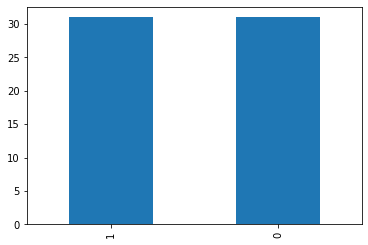

In [ ]:
df['gender'].value_counts().plot.bar()

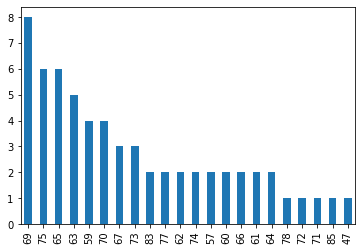

In [ ]:
df['age'].value_counts().plot.bar()

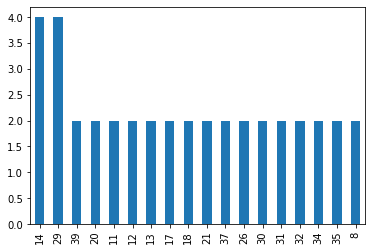

In [ ]:
df['UPDRS'][df['has_pd'] == 1].value_counts().plot.bar()

36 11 1


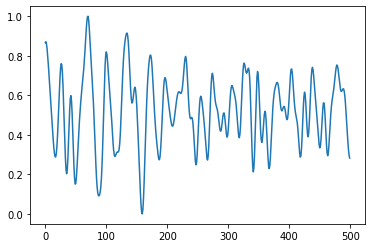

37 56 10


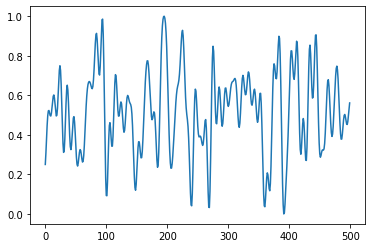

32 50 14


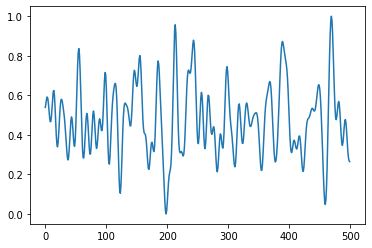

29 36 26


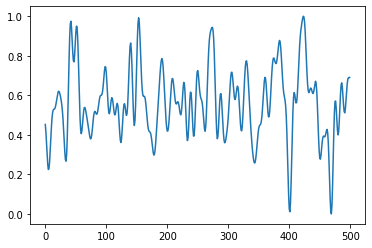

53 57 14


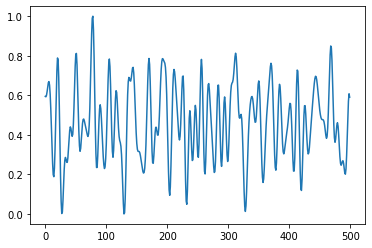

In [ ]:
for _ in range(5):
    data_index = np.random.randint(len(all_data))
    trial_index = np.random.randint(len(all_data[0]['data']))
    channel_index = np.random.randint(all_data[0]['data'][0].shape[1])
    print(data_index, trial_index, channel_index)
    plt.plot(all_data[data_index]['data'][trial_index][:, channel_index])
    plt.show()

### Moving the Data

In [ ]:
splited_data = list()
for i in range(len(all_data)):
    current = all_data[i]
    for j in range(current['data'].shape[0]):
        splited_data.append(
            copy.deepcopy(current)
        )
        splited_data[-1]['data'] = current['data'][j]

In [ ]:
len(splited_data)

3720

### Saving clean data

In [ ]:
splited_data[0].keys()

dict_keys(['data', 'age', 'gender', 'has_pd', 'taken_med', 'UPDRS'])

In [ ]:
all_inputs = np.array([x['data'] for x in splited_data])
all_inputs.shape

(3720, 500, 27)

In [ ]:
all_info = {
    'age': np.array([x['age'] for x in splited_data]), 
    'gender': np.array([x['gender'] for x in splited_data]), 
    'has_pd': np.array([x['has_pd'] for x in splited_data]), 
    'taken_med': np.array([x['taken_med'] for x in splited_data]), 
    'UPDRS': np.array([x['UPDRS'] for x in splited_data]), 
}

In [ ]:
scipy.io.savemat(
    'data/clean/clean_trials.mat', 
    {'trials': all_inputs}
)

In [ ]:
scipy.io.savemat('data/clean/clean_info.mat', all_info)

## Split signals by frequency

### Imports

In [8]:
!pip install mat73

In [8]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import mat73

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lhjmb4pe because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Data

There are 5 frequency bands defined on brainwaves that are defined like this:
* Delta: 0.5 -4 Hz
* Theta: 4 - 8 Hz
* Alpha: 8 - 12 Hz
* Beta: 12 - 30 Hz
* Gamma: 30 - 45 Hz

Spliting the data to this channels, we used the [bandpass filter](https://www.mathworks.com/help/signal/ref/bandpass.html) in matlab. There is `apply_bandpass` function that applies bandpass filter on the data. there is `split_frequency` script that applies this function on train, validation and test data.

In [9]:
splitted_trials = mat73.loadmat('data/clean/clean_trials_splited.mat')

In [10]:
splitted_trials = splitted_trials['result']

In [11]:
splitted_trials.keys()

dict_keys(['alpha', 'beta', 'delta', 'gamma', 'raw', 'theta'])

In [12]:
splitted_trials['broadband'] = splitted_trials.pop('raw')

In [13]:
splitted_trials.keys()

dict_keys(['alpha', 'beta', 'delta', 'gamma', 'theta', 'broadband'])

In [14]:
splitted_trials['alpha'].shape

(3720, 500, 27)

### Splited Frequency result

In [15]:
data_index = np.random.randint(3720, size=(1))[0]
channel_index = np.random.randint(27, size=(1))[0]

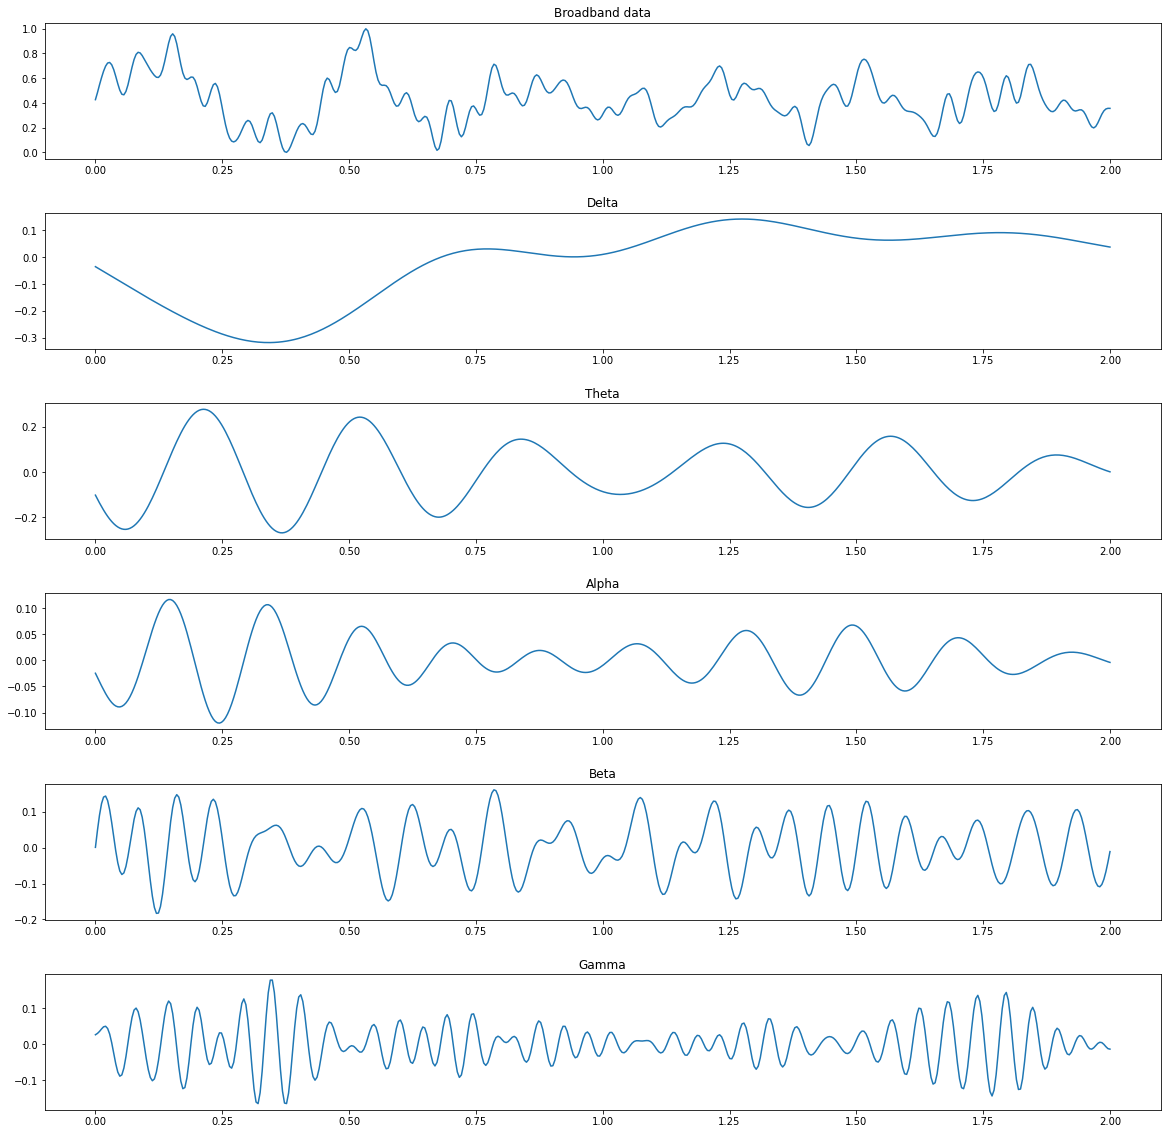

In [17]:
fig, axis = plt.subplots(6, 1, figsize=(20, 20))
x = np.linspace(0, 2, 500)

axis[0].plot(x, splitted_trials['broadband'][data_index, :, channel_index])
axis[0].title.set_text('Broadband data')

axis[1].plot(x, splitted_trials['delta'][data_index, :, channel_index])
axis[1].title.set_text('Delta')

axis[2].plot(x, splitted_trials['theta'][data_index, :, channel_index])
axis[2].title.set_text('Theta')

axis[3].plot(x, splitted_trials['alpha'][data_index, :, channel_index])
axis[3].title.set_text('Alpha')

axis[4].plot(x, splitted_trials['beta'][data_index, :, channel_index])
axis[4].title.set_text('Beta')

axis[5].plot(x, splitted_trials['gamma'][data_index, :, channel_index])
axis[5].title.set_text('Gamma')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig('images/splitted_frequency_results.png')

### Outputs

In [18]:
outputs = sio.loadmat('data/clean/clean_info.mat')

In [19]:
del outputs['__header__']
del outputs['__version__']
del outputs['__globals__']

In [20]:
outputs.keys()

dict_keys(['age', 'gender', 'has_pd', 'taken_med', 'UPDRS'])

In [21]:
for key in outputs.keys():
    outputs[key] = outputs[key].T

In [22]:
outputs['age'].shape

(3720, 1)

### Split Healthy and PD patients

There were 22 healty patients and 20 pd patients. PD patients had 2 type med off and med on. So from 3720 trials, first 1320 are healty, next 1200 are PD patients med off, and the last 1200 are PD patients med on.

In [23]:
HC = {
    key : splitted_trials[key][:1320] for key in splitted_trials.keys()
}

In [24]:
PD_off = {
    key : splitted_trials[key][1320:2520] for key in splitted_trials.keys()
}

In [25]:
PD_on = {
    key : splitted_trials[key][2520:] for key in splitted_trials.keys()
}

In [26]:
HC_labels = {
    key : outputs[key][:1320] for key in outputs.keys()
}

In [27]:
PD_off_labels = {
    key : outputs[key][1320:2520] for key in outputs.keys()
}

In [28]:
PD_on_labels = {
    key : outputs[key][2520:] for key in outputs.keys()
}

In [29]:
inputs = {
    'HC': HC, 
    'PD_off': PD_off, 
    'PD_on': PD_on
}

In [30]:
outputs = {
    'HC_labels': HC_labels,
    'PD_off_labels': PD_off_labels, 
    'PD_on_labels': PD_on_labels
}

In [32]:
with open('data/clean/inputs.pickle', 'wb+') as f:
  pickle.dump(inputs, f)

In [33]:
with open('data/clean/labels.pickle', 'wb+') as f:
  pickle.dump(outputs, f)